In [ ]:
install.packages(c("forecast", "tsibble", "psych", "tseries", "rugarch","tseries","FinTS","zoo"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘BH’, ‘TTR’, ‘truncnorm’, ‘future.apply’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’, ‘anytime’, ‘mnormt’, ‘GPArotation’, ‘quadprog’, ‘quantmod’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘xts’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’




In [ ]:
library(tidyverse)
library(forecast)
library(tsibble)
library(psych)
library(tseries)
library(rugarch)
library(TTR)
library(tseries)
library(FinTS)
library(zoo)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union



Attaching package: ‘psych’


The following objects are masked from ‘package:gg

In [ ]:
df <- read.csv("dataset_b.csv")
sales_ts <- ts(df$sales,
               start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]),
               frequency = 52)

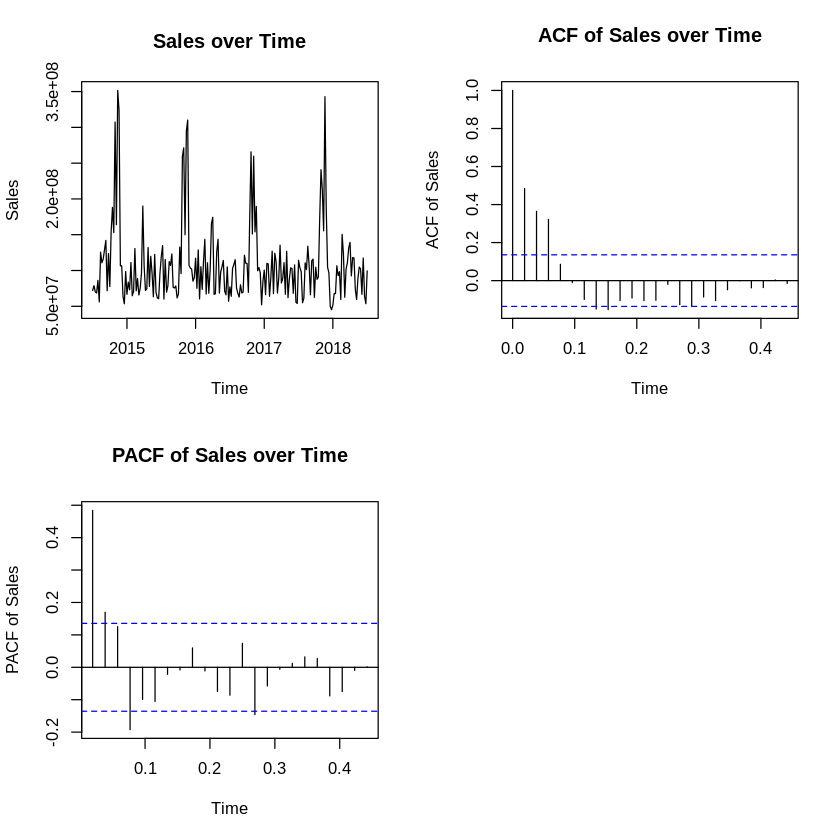

In [ ]:
par(mfrow = c(2, 2))
plot(sales_ts,
     main = "Sales over Time",
     ylab = "Sales",
     xlab = "Time")
acf(sales_ts,
     main = "ACF of Sales over Time",
     ylab = "ACF of Sales",
     xlab = "Time")
pacf(sales_ts,
      main = "PACF of Sales over Time",
      ylab = "PACF of Sales",
      xlab = "Time")

In [ ]:
adf.test(sales_ts)

Warning message in adf.test(sales_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  sales_ts
Dickey-Fuller = -6.0328, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


In [ ]:
arima_sales  <- auto.arima(sales_ts)
summary(arima_sales)

Series: sales_ts 
ARIMA(0,0,1)(0,1,1)[52] 

Coefficients:
          ma1     sma1
      -0.1294  -0.5870
s.e.   0.0753   0.1556

sigma^2 = 1.517e+15:  log likelihood = -2976.39
AIC=5958.77   AICc=5958.93   BIC=5967.94

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set -2166788 33538357 21825810 -6.682839 22.06546 0.6656732
                    ACF1
Training set -0.01356842


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(0,1,1)[52]
Q* = 35.158, df = 40, p-value = 0.6877

Model df: 2.   Total lags used: 42



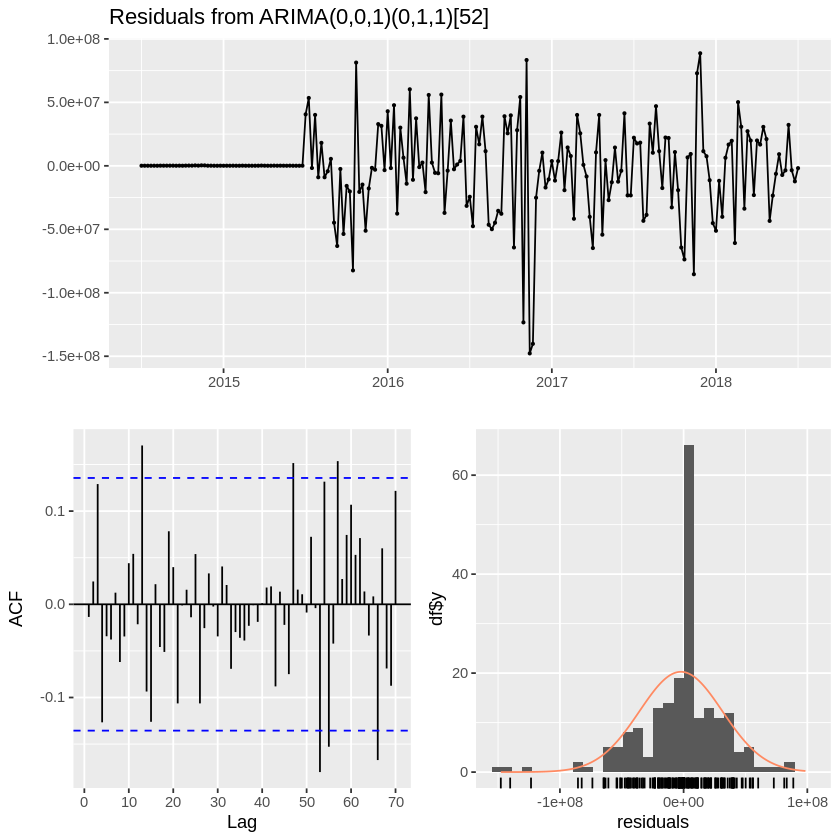

In [ ]:
checkresiduals(arima_sales)

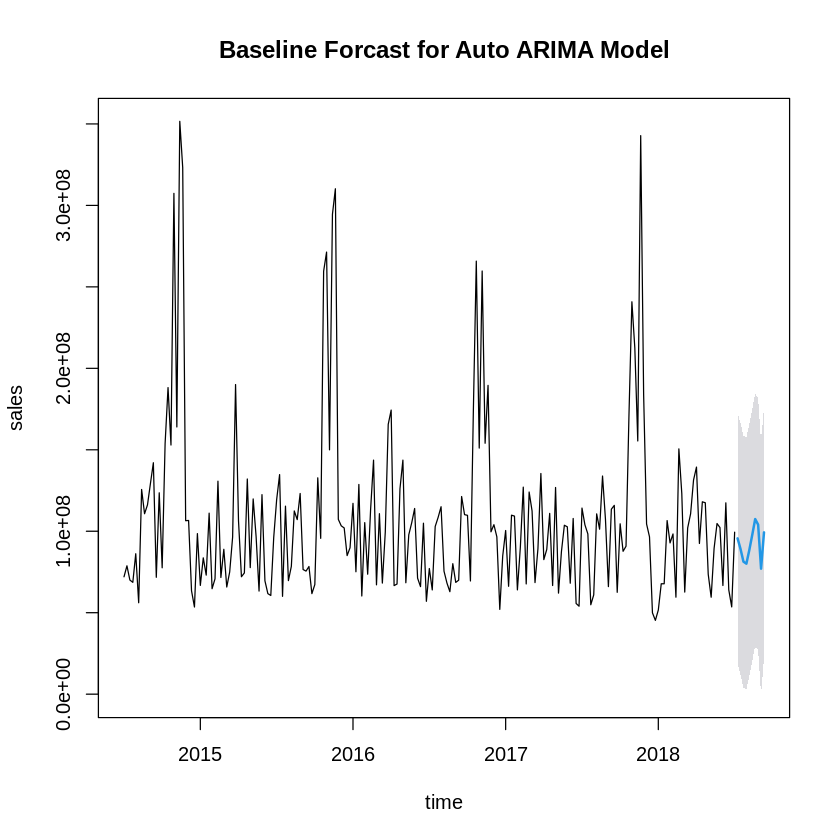

In [ ]:
arima_forcast<-forecast(arima_sales, h = 10, level = 95)
plot(arima_forcast,main="Baseline Forcast for Auto ARIMA Model",xlab = "time",ylab = "sales")

# **Prewhitening**

In [ ]:
ad_ts <- ts(df$mdsp_on, start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]), frequency = 52)
arima_ad<-auto.arima(ad_ts)
summary(arima_ad)

Series: ad_ts 
ARIMA(0,1,2)(1,1,0)[52] 

Coefficients:
          ma1      ma2     sar1
      -0.8851  -0.0729  -0.4707
s.e.   0.0750   0.0742   0.0838

sigma^2 = 1.021e+10:  log likelihood = -2025.27
AIC=4058.55   AICc=4058.81   BIC=4070.75

Training set error measures:
                   ME     RMSE     MAE       MPE     MAPE      MASE
Training set 7732.038 86459.46 59511.3 -7.189601 29.32381 0.6575249
                     ACF1
Training set -0.008183836

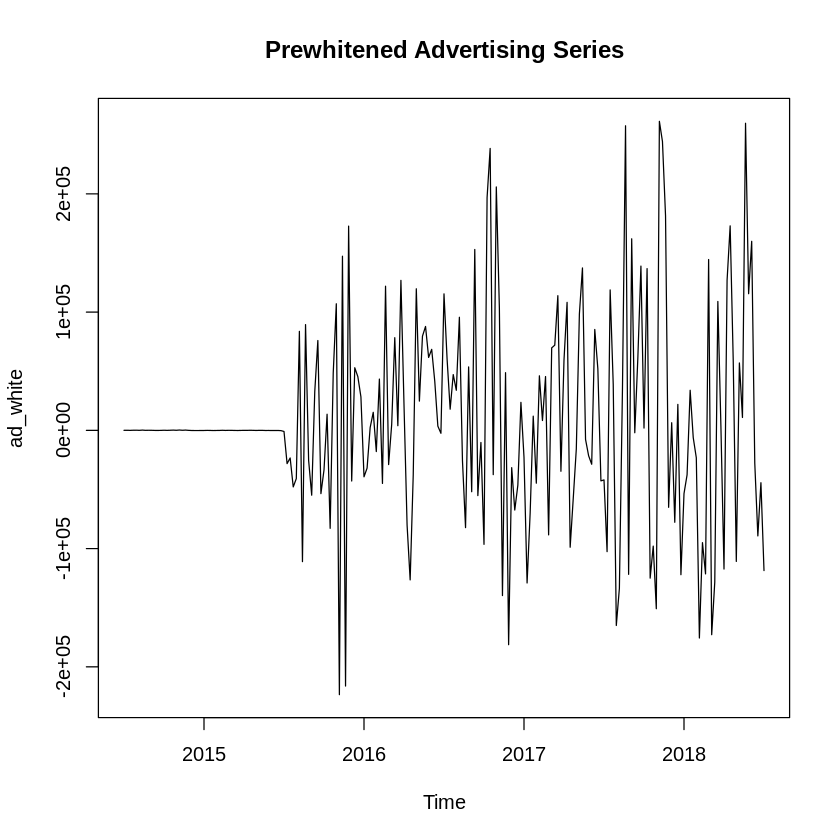

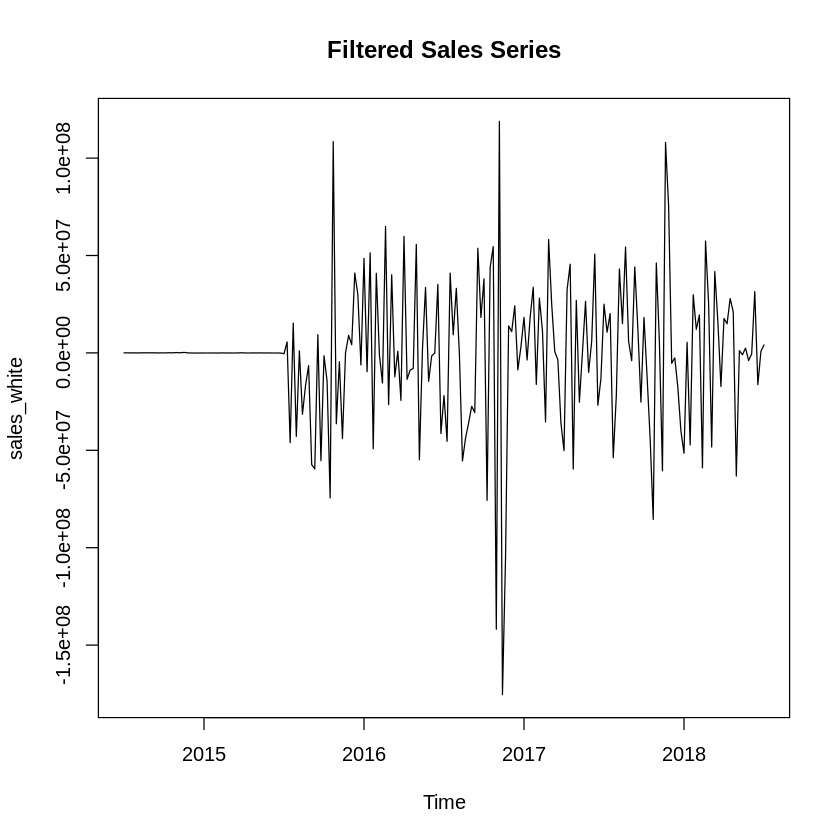

In [ ]:
ad_white <- residuals(arima_ad)
sales_white <- residuals(Arima(sales_ts,
                               order = c(0,1,2),
                               seasonal = list(order=c(1,1,0), period=52),
                               fixed = arima_ad$coef))

ts.plot(ad_white, main="Prewhitened Advertising Series")
ts.plot(sales_white, main="Filtered Sales Series")

# **Cross-correlation Identification**

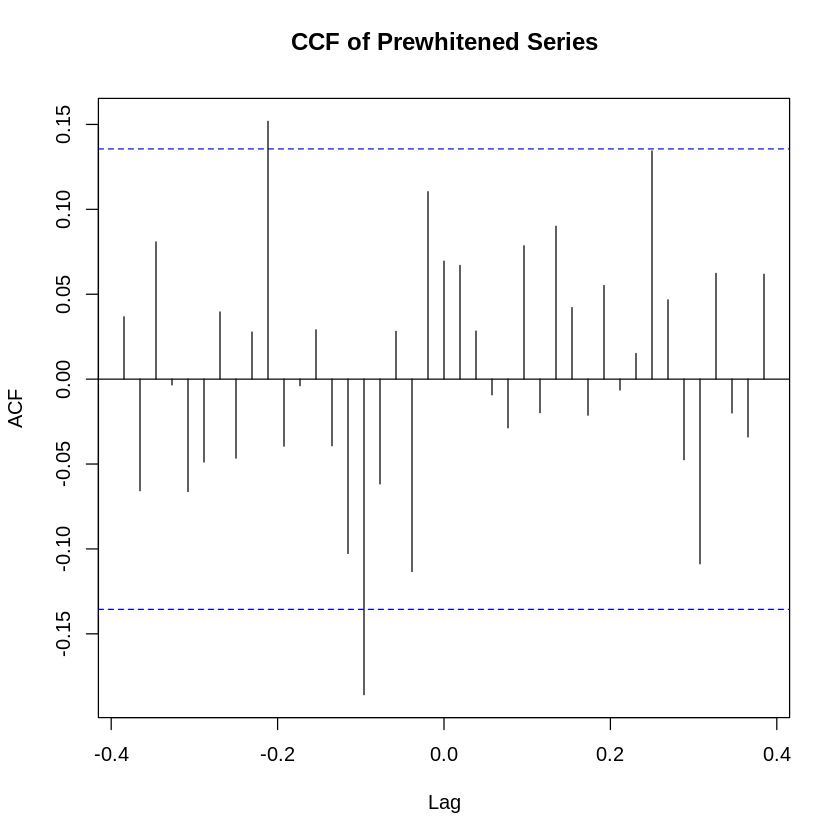

In [ ]:
ccf(ad_white, sales_white, main="CCF of Prewhitened Series")

# **ARIMAX/Transfer Function model**

In [ ]:
ads_lag10 <- stats::lag(ad_ts, -10)
ads_lag16 <- stats::lag(ad_ts, -16)

combined_ts <- ts.intersect(sales = sales_ts,
                           ad_lag10 = ads_lag10,
                           ad_lag16 = ads_lag16)

sales_aligned <- combined_ts[, "sales"]
X_aligned <- combined_ts[, c("ad_lag10", "ad_lag16")]

sales_scaled <- scale(sales_aligned)

ad_lag10_scaled <- scale(X_aligned[,1])
ad_lag16_scaled <- scale(X_aligned[,2])

arimax_tf <- arima(sales_scaled, order = c(0, 0, 1),
                       xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))
summary(arimax_tf)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = sales_scaled, order = c(0, 0, 1), xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))

Coefficients:
         ma1  intercept  ad_lag10_scaled  ad_lag16_scaled
      0.4096    -0.0014          -0.0320          -0.0855
s.e.  0.0647     0.0908           0.0751           0.0756

sigma^2 estimated as 0.8039:  log likelihood = -252.88,  aic = 513.77

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 51.866, df = 38, p-value = 0.06622

Model df: 1.   Total lags used: 39



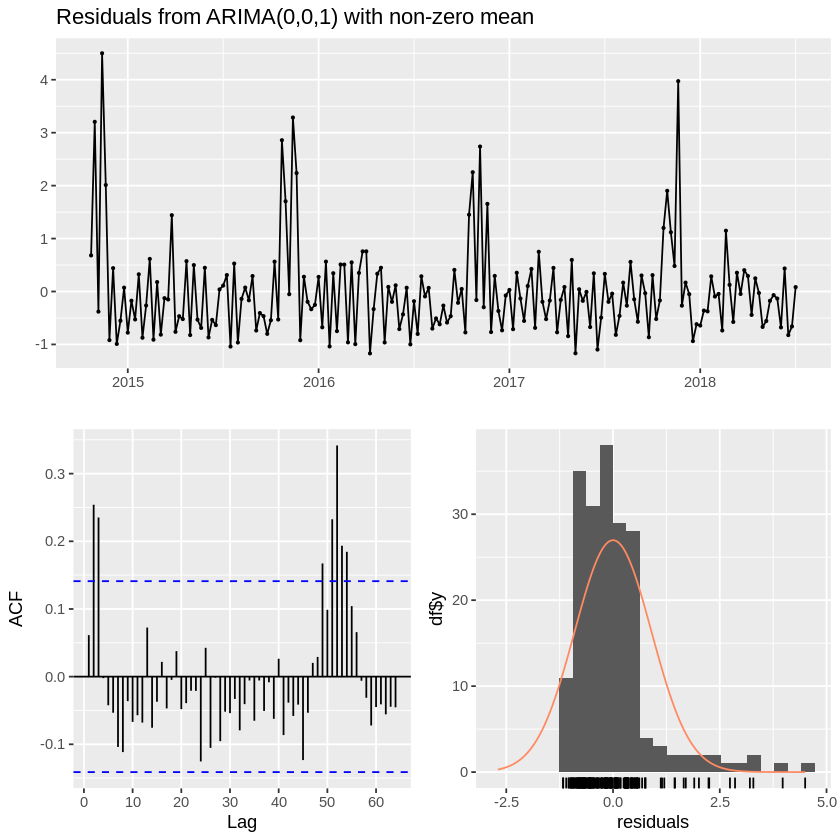

In [ ]:
checkresiduals(arimax_tf)

In [ ]:
ArchTest(residuals(arimax_tf))


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(arimax_tf)
Chi-squared = 18.716, df = 12, p-value = 0.09562


# **Forecast**

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


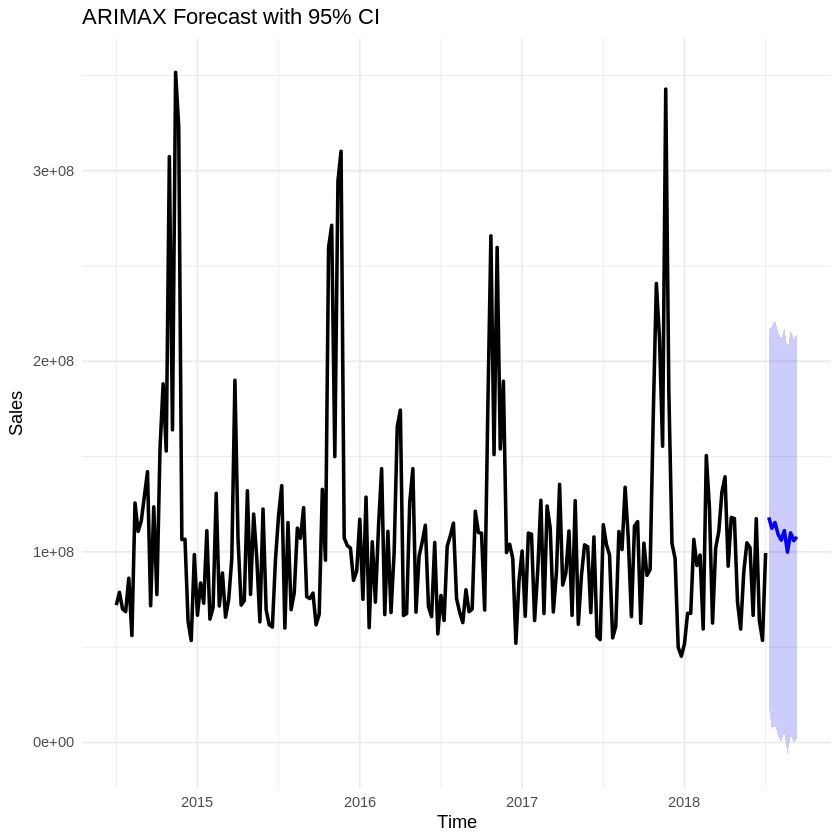

In [ ]:
center <- c(attr(ad_lag10_scaled, "scaled:center"),
            attr(ad_lag16_scaled, "scaled:center"))

scale_ <- c(attr(ad_lag10_scaled, "scaled:scale"),
            attr(ad_lag16_scaled, "scaled:scale"))

future_X_scaled <- scale(future_X, center = center, scale = scale_)

arimax_forecast <- predict(arimax_tf, n.ahead = h, newxreg = future_X_scaled)

forecast_scaled <- arimax_forecast$pred

forecast_original <- forecast_scaled * attr(sales_scaled, "scaled:scale") + attr(sales_scaled, "scaled:center")

upper <- forecast_original + 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")
lower <- forecast_original - 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")

time_all <- as.numeric(time(sales_ts))
time_forecast <- seq(from = tail(time_all, 1) + 1/52,
                     by = 1/52,
                     length.out = h)

plot_df <- data.frame(
  time = c(time_all, time_forecast),
  sales = c(as.numeric(sales_ts), rep(NA, h)),
  forecast = c(rep(NA, length(sales_ts)), forecast_original),
  lower = c(rep(NA, length(sales_ts)), lower),
  upper = c(rep(NA, length(sales_ts)), upper)
)

ggplot(plot_df) +
  geom_line(aes(x = time, y = sales), color = "black", size = 1) +
  geom_line(aes(x = time, y = forecast), color = "blue", size = 1) +
  geom_ribbon(aes(x = time, ymin = lower, ymax = upper), fill = "blue", alpha = 0.2) +
  labs(x = "Time", y = "Sales", title = "ARIMAX Forecast with 95% CI") +
  theme_minimal();